<a href="https://colab.research.google.com/github/lupis30puc/BERT_interpretation_with_RF/blob/main/10epochs_trainning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Yelp dataset on kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset)

12,993 samples from the Yelp Dataset Challenge 2020. 
Divided on train, validation and test subsets. 

Their corresponding sizes are: 10,394 train samples, 2,599 test samples.


Tutorial on which I support: 
[BERT Fine-Tunning](http://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification)
[Colab: BERT for sequential classification](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=DEfSbAA4QHas)


**On this notebook I will run the model with:**

**max length = 128 and 99** --these are the 95 and 90 percentiles of the dataset length 

**batch size = 32 and 16**

**epochs = 10**

### According to the made experiments those are the best parameters.

## Set up

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 7.6MB/s 
     |████████████████████████████████| 3.2MB 49.8MB/s 
     |████████████████████████████████| 890kB 53.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=27551cbf7b8336d0c2f72c1098ed71ba0a1f5d6d0f31b804998a83854353ef24
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## GPU

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Loading the pre-processed dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time

In [ ]:
# Loading the train and test datasets obatined on the preprocessing notebook
train_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_train_10394.pkl')
validation_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_test_2599.pkl')

In [ ]:
print(train_df.shape, validation_df.shape)

(10394, 5) (2599, 5)


In [ ]:
# Get the lists of reviews and their labels.
train_x = train_df.clean_text.values
train_y = train_df.label.values

val_x = validation_df.clean_text.values
val_y = validation_df.label.values

# BERT

In [ ]:
maxlen = 99

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 10

### BERT Tokenizer to create input ids and masks

In [ ]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
def get_inputs_ids_mask(reviews, labels):
  %%time
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in reviews:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = maxlen, # SETTING THE MAX TO 128 tokens --> 95 PERCENTILE
                          padding = 'max_length',
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          truncation = True
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', reviews[0])
  print('Token IDs:', input_ids[0])
  return input_ids, attention_masks, labels

In [ ]:
train_ii, train_masks, train_labels = get_inputs_ids_mask(train_x, train_y)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.53 µs
Original:  second best pool las vegas pay commit day drink overpriced drinks hits blast speakers won let bring alcohol nice check pools fun creative kids especially adults water slide massage spa flamingo pretty outstanding
Token IDs: tensor([  101,  2117,  2190,  4770,  5869,  7136,  3477, 10797,  2154,  4392,
         2058, 18098,  6610,  2094,  8974,  4978,  8479,  7492,  2180,  2292,
         3288,  6544,  3835,  4638, 12679,  4569,  5541,  4268,  2926,  6001,
         2300,  7358, 21881, 12403, 19091,  2080,  3492,  5151,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0

In [ ]:
val_ii, val_masks, val_labels = get_inputs_ids_mask(val_x, val_y)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Original:  positives good location staff reasonably friendly negatives dry manis pedis advertise website update site base coat coat blobbed attention coat cover color nail nails filed totally random lenths shapes shorter end fingers longer pedi woman wasn paying attention ended filing skin bled cute tea menu offer definitely expensive getting answer phone pedi station isn comfortable slightly padded bench notes staff looks surprised sure come ask work
Token IDs: tensor([  101,  3893,  2015,  2204,  3295,  3095, 16286,  5379,  4997,  2015,
         4318, 23624,  2015, 21877, 10521,  4748, 16874,  5562,  4037, 10651,
         2609,  2918,  5435,  5435,  1038,  4135, 15499,  3086,  5435,  3104,
         3609, 13774, 10063,  6406,  6135,  6721, 15307,  7898, 10466,  7820,
         2203,  3093,  2936, 21877,  4305,  2450,  2347,  7079,  3086,  3092,
        15242,  3096, 23919, 10140,  5572, 12183,  3749,  5791,  6450,  2893,
 

### Creating tensor Datasets and DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_ii, train_masks, train_labels)
val_dataset = TensorDataset(val_ii, val_masks, val_labels)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially. FROM THE 2ND DIVISION
            batch_size = batch_size # Evaluate with this batch size.
        )

### Intializing BertForSequenceClassification model and helper functions

In [ ]:
%%time
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. # It can be increased for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CPU times: user 11.6 s, sys: 2.27 s, total: 13.9 s
Wall time: 21.8 s


optimizer

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup



# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Training

---



In [ ]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        
         

      # Perform a forward pass (evaluate the model on this training batch).
      # The documentation for this `model` function is here: 
      # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
      # It returns different numbers of parameters depending on what arguments
      # arge given and what flags are set. For our useage here, it returns
      # the loss (because we provided labels) and the "logits"--the model
      # outputs prior to activation.
        loss_logits_ = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)

        loss = loss_logits_[0]
        logits_t = loss_logits_[1]

        logits_t_cpu = logits_t.detach().cpu().numpy()
        train_pred = np.argmax(logits_t_cpu, axis=1).flatten()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            loss_logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = loss_logits[0]
            logits_val = loss_logits[1]
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits_val = logits_val.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        val_pred = np.argmax(logits_val, axis=1).flatten()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits_val, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    325.    Elapsed: 0:00:22.
  Batch    80  of    325.    Elapsed: 0:00:46.
  Batch   120  of    325.    Elapsed: 0:01:09.
  Batch   160  of    325.    Elapsed: 0:01:31.
  Batch   200  of    325.    Elapsed: 0:01:54.
  Batch   240  of    325.    Elapsed: 0:02:17.
  Batch   280  of    325.    Elapsed: 0:02:39.
  Batch   320  of    325.    Elapsed: 0:03:02.

  Average training loss: 0.31
  Training epcoh took: 0:03:05

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.32
  Validation took: 0:00:16

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    325.    Elapsed: 0:00:23.
  Batch    80  of    325.    Elapsed: 0:00:46.
  Batch   120  of    325.    Elapsed: 0:01:08.
  Batch   160  of    325.    Elapsed: 0:01:31.
  Batch   200  of    325.    Elapsed: 0:01:54.
  Batch   240  of    325.    Elapsed: 0:02:16.
  Batch   280  of    325.    Elapsed: 0:02:39.
  Batch   320  of    325.    Elapsed: 0:03:02.

  Aver

# Summary of training process

In [ ]:
# stats of max length = 99 and 10 epochs and batch size = 16
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats_99 = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats_99 = df_stats_99.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats_99

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,3.22e-01,0.27,0.91,0:03:06,0:00:15
2,1.90e-01,0.26,0.91,0:03:09,0:00:15
3,1.08e-01,0.41,0.91,0:03:09,0:00:14
4,6.15e-02,0.40,0.92,0:03:08,0:00:15
5,3.08e-02,0.56,0.91,0:03:07,0:00:14
6,2.00e-02,0.57,0.91,0:03:07,0:00:14
7,1.56e-02,0.58,0.92,0:03:07,0:00:14
8,1.10e-02,0.61,0.92,0:03:07,0:00:14
9,7.60e-03,0.62,0.92,0:03:07,0:00:14


In [ ]:
# stats of max length = 99 and 10 epochs and batch size = 32
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats_99b = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats_99b = df_stats_99b.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats_99b

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,3.05e-01,0.32,0.88,0:03:05,0:00:16
2,1.75e-01,0.22,0.92,0:03:04,0:00:16
3,1.00e-01,0.38,0.91,0:03:04,0:00:16
4,6.18e-02,0.43,0.91,0:03:03,0:00:16
5,3.59e-02,0.45,0.92,0:03:03,0:00:16
6,1.80e-02,0.49,0.92,0:03:03,0:00:16
7,1.08e-02,0.53,0.91,0:03:03,0:00:16
8,7.58e-03,0.59,0.91,0:03:03,0:00:16
9,5.80e-03,0.61,0.92,0:03:03,0:00:16


In [ ]:
df_stats_99[['Training Loss', 'Valid. Loss', 'Valid. Accur.']].mean().apply(lambda x: round(x, 2))

Training Loss    0.08
Valid. Loss      0.49
Valid. Accur.    0.91
dtype: float64

In [ ]:
df_stats_99b[['Training Loss', 'Valid. Loss', 'Valid. Accur.']].mean().apply(lambda x: round(x, 2)) #new

Training Loss    0.07
Valid. Loss      0.46
Valid. Accur.    0.91
dtype: float64

In [ ]:
df_stats_99b.to_pickle('/content/drive/MyDrive/Yelp/loss_accuracy_results_2df/stats_99_10e_32')

Explanation

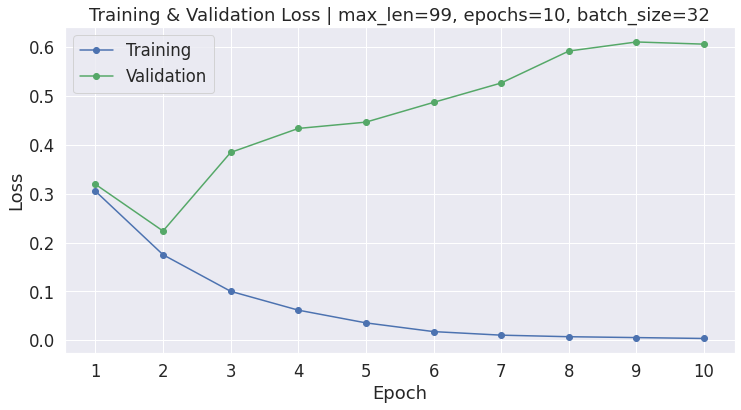

In [ ]:
# reults of max length = 99 and 10 epochs and batch size = 32

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats_99b['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats_99b['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss | max_len=99, epochs=10, batch_size=32")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3,4,5,6,7,8,9,10])
plt.savefig('/content/drive/MyDrive/Yelp/loss_accuracy_results_2df/loss_99_10e_32', format='jpg') #saving the graph
plt.show()